In [1]:
import numpy as np
from scipy import sparse
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
from matplotlib import pylab as plt

class CLF:
    def __init__(self, c=1):
        self.pipeline = Pipeline([
#             ('clf', ComplementNB(alpha))
#             ('clf', MultinomialNB(alpha, fit_prior=False))
            ('clf', LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=2000, C=c))
        ])
        
    def fit(self, matrix, label):
        self.pipeline.fit(matrix, label)
        
    def predict(self, matrix):
        return self.pipeline.predict(matrix)

    def evaluate(self, y_true, y_pre):
        assert len(y_true) == len(y_pre)
        acc = accuracy_score(y_true, y_pre)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pre, average="macro")
        return acc, precision, recall, f1
    
def evaluate(y_true, y_pre):
        assert len(y_true) == len(y_pre)
        acc = accuracy_score(y_true, y_pre)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pre, average="macro")
        return acc, precision, recall, f1
    
def readCsv(filename):
    df = pd.read_csv(filename)
    return df['id'], df['text'], df['label']

In [2]:
# Setting up for k-fold cross validation
print('Setting up k-fold...')

_, train_text, train_label = readCsv('data/train.csv')
test_id, test_text, _ = readCsv('data/test.csv')

ngram = (1, 5)
stop_words = set(stopwords.words('english') + list(string.punctuation) + ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'])

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet as wn

def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']
def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']
def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']
def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return wn.NOUN

def tokenizer(text):
    lemmatizer = WordNetLemmatizer()
    tokens = [word for word in nltk.word_tokenize(text) if len(word) > 1 and word not in stop_words and not word.isnumeric()]
    token_pos = nltk.pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(item, penn_to_wn(pos)) for item, pos in token_pos]
    return lemmas

# train_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=ngram, lowercase=True, \
#                                    min_df=3, max_df=0.999, use_idf=True, tokenizer=tokenizer)
train_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=ngram, lowercase=True, \
                                   min_df=3, max_df=0.999, use_idf=False)
train_data_matrix = train_vectorizer.fit_transform(train_text)
print('Train:', train_data_matrix.shape)
print('Vocab:', len(train_vectorizer.vocabulary_))
# test_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=ngram, lowercase=True, \
#                                   vocabulary=train_vectorizer.vocabulary_, use_idf=True, tokenizer=tokenizer)
test_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=ngram, lowercase=True, \
                                  vocabulary=train_vectorizer.vocabulary_, use_idf=False)
test_data_matrix = test_vectorizer.fit_transform(test_text)
print('Test:', test_data_matrix.shape)

Setting up k-fold...
Train: (16000, 123770)
Vocab: 123770
Test: (4491, 123770)


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

c_choices = np.random.uniform(1.3, 1.8, 5)
c_acc = {}

kf = KFold(n_splits=5)

for c in c_choices:
    accuracies = []
    for train_index, test_index in kf.split(train_data_matrix):
        clf = CLF(c=c)
        clf.fit(train_data_matrix[train_index], train_label[train_index])
        train_data_pre = clf.predict(train_data_matrix[test_index])
        print(train_data_pre)
        acc, precision, recall, f1 = clf.evaluate(train_label[test_index], train_data_pre)
        print("c: %f\tAccuracy: %f\tPrecision: %f\tRecall: %f\tMacro-F1: %f" % (c, acc, precision, recall, f1))
        print(confusion_matrix(train_label[test_index], train_data_pre))
        accuracies.append(acc)
    c_acc[c] = accuracies

[4 2 4 ..., 5 5 5]
c: 1.565197	Accuracy: 0.607812	Precision: 0.562893	Recall: 0.525476	Macro-F1: 0.530907
[[ 204   64    5   12   12]
 [  82  124   41   63   25]
 [  14   57   74  181   50]
 [   6   16   33  533  347]
 [   5    3    5  234 1010]]
[5 4 5 ..., 5 5 5]
c: 1.565197	Accuracy: 0.619687	Precision: 0.572393	Recall: 0.518158	Macro-F1: 0.534651
[[ 145   51    7    8   15]
 [  49   97   43   45   33]
 [  10   49   83  149   45]
 [   3   11   37  487  443]
 [   2    2    3  212 1171]]
[5 5 5 ..., 5 4 5]
c: 1.565197	Accuracy: 0.599063	Precision: 0.548163	Recall: 0.500010	Macro-F1: 0.514491
[[ 130   61   13    4    9]
 [  52   99   51   58   27]
 [  11   46   77  169   51]
 [   2   17   25  544  383]
 [   1    8    8  287 1067]]
[5 5 5 ..., 5 4 5]
c: 1.565197	Accuracy: 0.609062	Precision: 0.577108	Recall: 0.520081	Macro-F1: 0.537198
[[ 179   57    8   11   11]
 [  53  102   49   70   26]
 [   3   42   83  188   36]
 [   2   16   31  533  395]
 [   4    3    3  243 1052]]
[5 5 4 ..., 

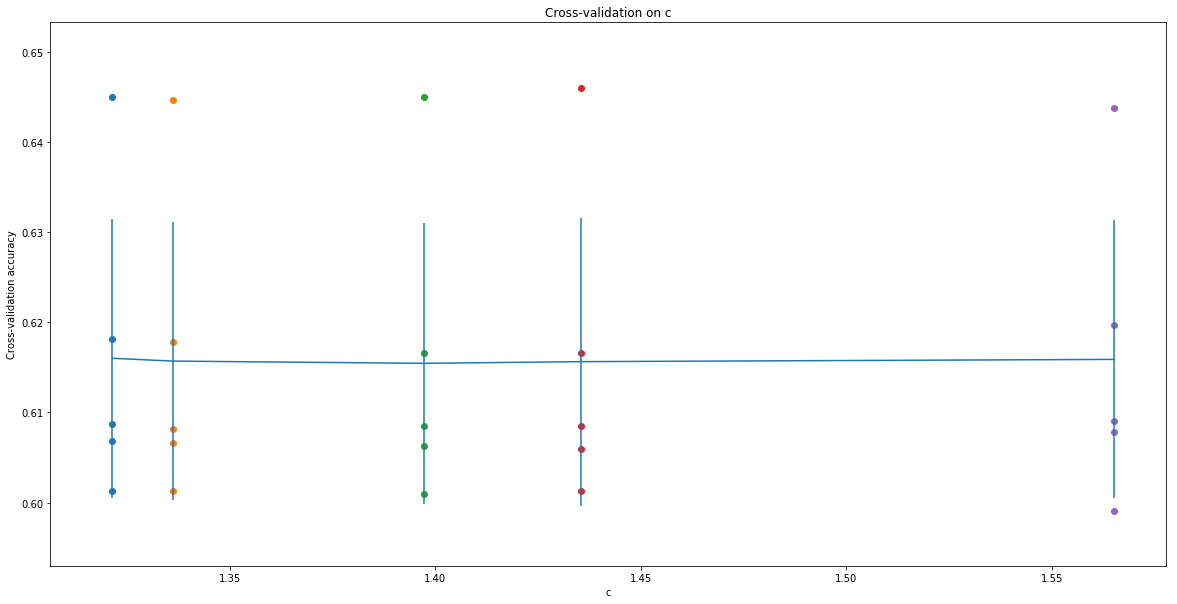

Best accuracy: 0.616 at c = 1.32145495277


In [12]:
plt.figure(figsize=(20,10))
c_choices = sorted(c_choices)
# plot the raw observations
for c in c_choices:
    accuracies = c_acc[c]
    plt.scatter([c] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(c_acc.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(c_acc.items())])
plt.errorbar(c_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on c')
plt.xlabel('c')
plt.ylabel('Cross-validation accuracy')
plt.show()

best_c = [k for k,v in sorted(c_acc.items())][np.argmax(accuracies_mean)]
print('Best accuracy:', np.max(accuracies_mean), 'at c =', best_c)

In [10]:
clf = CLF(best_c)
clf.fit(train_data_matrix, train_label)
train_data_pre = clf.predict(train_data_matrix)
acc, precision, recall, f1 = clf.evaluate(train_label, train_data_pre)
print("alpha: %f\tAccuracy: %f\tPrecision: %f\tRecall: %f\tMacro-F1: %f" % (best_c, acc, precision, recall, f1))
print(confusion_matrix(train_label, train_data_pre))

test_data_pre = clf.predict(test_data_matrix)

sub_df = pd.DataFrame()
sub_df["id"] = test_id
sub_df["pred"] = test_data_pre
sub_df.to_csv("submission.csv", index=False)

alpha: 1.652955	Accuracy: 0.845187	Precision: 0.867320	Recall: 0.804186	Macro-F1: 0.829467
[[1056   62   16   24   21]
 [  53 1109   69  143   66]
 [  21   68 1050  429  148]
 [  10   21   35 3844  864]
 [   5    6    9  407 6464]]


In [6]:
from sklearn.linear_model import LogisticRegression

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(train_data_matrix):
    clf = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=2000)
    clf.fit(train_data_matrix[train_index], train_label[train_index])
    train_data_pre = clf.predict(train_data_matrix[test_index])
    print(train_data_pre)
    acc, precision, recall, f1 = evaluate(train_label[test_index], train_data_pre)
    print("alpha: %f\tAccuracy: %f\tPrecision: %f\tRecall: %f\tMacro-F1: %f" % (alpha, acc, precision, recall, f1))
    print(confusion_matrix(train_label[test_index], train_data_pre))

    clf = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=2000)
clf.fit(train_data_matrix, train_label)
train_data_pre = clf.predict(train_data_matrix)
acc, precision, recall, f1 = evaluate(train_label, train_data_pre)
print("alpha: %f\tAccuracy: %f\tPrecision: %f\tRecall: %f\tMacro-F1: %f" % (best_alpha, acc, precision, recall, f1))

[4 2 4 ..., 5 5 5]
alpha: 0.992621	Accuracy: 0.608437	Precision: 0.570716	Recall: 0.521554	Macro-F1: 0.527608
[[ 208   58    4   13   14]
 [  83  113   37   65   37]
 [  10   52   69  186   59]
 [   5   13   23  540  354]
 [   6    3    4  227 1017]]
[5 4 5 ..., 5 5 5]
alpha: 0.992621	Accuracy: 0.615000	Precision: 0.573388	Recall: 0.505768	Macro-F1: 0.524530
[[ 143   50    8    9   16]
 [  47   90   37   50   43]
 [   9   43   73  161   50]
 [   2    9   29  487  454]
 [   2    3    1  209 1175]]
[5 5 5 ..., 5 4 5]
alpha: 0.992621	Accuracy: 0.597812	Precision: 0.550640	Recall: 0.492465	Macro-F1: 0.507834
[[ 131   57   11    8   10]
 [  50   93   41   64   39]
 [  10   42   67  181   54]
 [   2   15   22  540  392]
 [   1    8    7  273 1082]]
[5 5 5 ..., 5 4 5]
alpha: 0.992621	Accuracy: 0.605313	Precision: 0.577954	Recall: 0.508691	Macro-F1: 0.528485
[[ 172   59    8   13   14]
 [  49   96   48   75   32]
 [   4   38   78  192   40]
 [   2   14   22  529  410]
 [   2    3    2  236 106

In [7]:
test_data_pre = clf.predict(test_data_matrix)

sub_df = pd.DataFrame()
sub_df["id"] = test_id
sub_df["pred"] = test_data_pre
sub_df.to_csv("submission_logitistic.csv", index=False)